# Build  spectra for AuxTel with new spectractor (September 2021): Part 1

# For processing September 09 Planetary Nebula

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- cretion date : September 22th  2021
- version v3


**This notebook is to help for finding the position of order 0 of the target**

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and anaconda3_auxtel_v2 (no libradtran)

# Imports

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [69]:
from iminuit import Minuit
import iminuit

In [70]:
iminuit.__version__

'2.7.0'

In [71]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [72]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [73]:
from astropy.visualization import simple_norm

In [74]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [75]:
from astroquery.simbad import Simbad

In [76]:
from astropy.wcs import WCS
from astropy.io import fits

In [77]:
FLAG_REMOVE_WCS=False

# Path

In [78]:
HOSTCC=False

In [79]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/2021-09-09")
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"data/2021/holo/localreduced/2021-07-06")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/2021-09-09")

# Function

In [80]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [81]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

# Logbook for file selection

In [82]:
filename_logbook='logbooks/auxtelholologbook_PNG_2021_09_09_v2.0.csv'

In [83]:
df=pd.read_csv(filename_logbook,index_col=0)

In [84]:
pd.set_option('display.max_rows', None)

In [85]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-09-09T23:53:55.100,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000165_...,165,PNG321.0+03.9,empty_1,holo4_003,1.380357,10.0,...,9.2,16.0,4.0,300.0,1750.0,NaN,NaN,,1.0,1.0
1,1,2021-09-09T23:54:18.095,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000166_...,166,PNG321.0+03.9,empty_1,holo4_003,1.381613,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
2,2,2021-09-09T23:54:41.122,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000167_...,167,PNG321.0+03.9,empty_1,holo4_003,1.382874,10.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
3,3,2021-09-09T23:55:04.180,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000168_...,168,PNG321.0+03.9,empty_1,holo4_003,1.384148,30.0,...,9.1,16.0,3.6,300.0,1750.0,NaN,NaN,,1.0,1.0
4,4,2021-09-09T23:55:47.196,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000169_...,169,PNG321.0+03.9,empty_1,holo4_003,1.386523,30.0,...,9.0,17.0,3.1,300.0,1750.0,NaN,NaN,,1.0,1.0
5,5,2021-09-09T23:56:30.224,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000170_...,170,PNG321.0+03.9,empty_1,holo4_003,1.388908,30.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
6,6,2021-09-09T23:57:13.142,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000171_...,171,PNG321.0+03.9,empty_1,holo4_003,1.391300,60.0,...,9.0,16.0,3.9,300.0,1750.0,NaN,NaN,,1.0,1.0
7,7,2021-09-10T00:04:18.230,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000174_...,174,PNG321.0+03.9,empty_1,holo4_003,1.415803,0.0,...,8.9,15.0,3.7,300.0,1750.0,NaN,NaN,,1.0,1.0
8,8,2021-09-10T00:06:01.239,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000175_...,175,PNG321.0+03.9,empty_1,holo4_003,1.421962,60.0,...,8.9,15.0,3.8,300.0,1750.0,NaN,NaN,,1.0,1.0
9,9,2021-09-10T00:07:14.156,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_empty_PNG321.0+03.9_20210909_000176_...,176,PNG321.0+03.9,empty_1,holo4_003,1.426365,60.0,...,8.9,15.0,4.4,300.0,1750.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [86]:
target_name="PNG321.0+03.9"

In [87]:
sky_coord=SkyCoord.from_name(target_name)
sky_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [88]:
idx=10

In [89]:
myhome=os.getenv("HOME")

In [90]:
dir_images=path_images

In [91]:
filename_image=df['file'][idx]
filename_image

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

In [92]:
file_target(filename_image)

'PNG321.0+03.9'

## Configuration file 

Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [93]:
filename=os.path.join(dir_images,filename_image)
output_directory="./outputs_process_holo_PNG"
output_figures="figures_process_holo_PNG"
guess = [250,2600]
disperser_label = "holo4_003"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)
# standard configuration
# config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY (dispersion rotation angle)
config="./config/auxtel_PNG.ini"

target = file_target(filename_image)[0]

In [94]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
if not os.path.isdir(output_figures):
    os.mkdir(output_figures)

# Configuration of the running mode

In [95]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [96]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Transform the input file

- adaptation to Spectractor (master branch) for Auxtel

In [97]:
from shutil import copyfile

In [98]:
copyfile(filename,filename_image)

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

In [99]:
from astropy.io import fits

In [100]:
hdu = fits.open(filename_image)

In [101]:
hdu.info()

Filename: holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     124   (4072, 4000)   float32   


In [102]:
header=hdu[0].header
image=hdu[0].data

In [103]:
hdu.close()

## Rotate the image as expected by Spectractor

In [104]:
rot_image=np.flip(np.flip(image, 1), 0)
rot_image=np.flip(image, 1)

In [105]:
# Create an ImageNormalize object
# norm = simple_norm(image, 'log')

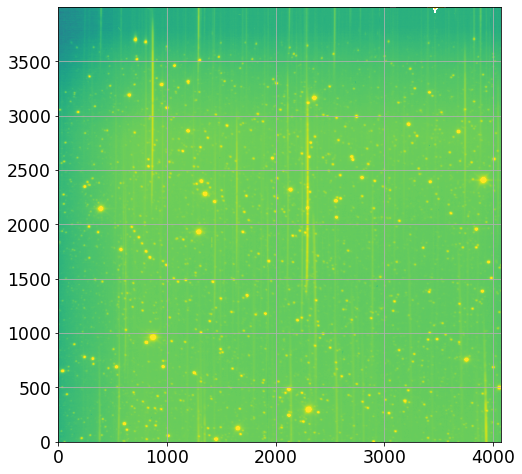

In [106]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1)
ax.imshow(rot_image,origin="lower",norm=LogNorm(0.1,1000))
ax.grid()
plt.show()

In [107]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-09-10T00:08:53.255'                                             
DATE-OBS= '2021-09-10T00:08:27.395'                                             
DATE-BEG= '2021-09-10T00:08:27.395'                                             
DATE-END= '2021-09-10T00:09:27.622'                                             
MJD     =     59467.0061719347                                                  
MJD-OBS =     59467.00587262

In [108]:
wcs = WCS(header)

Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-04 15:17:04  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


In [109]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 224.970833333333  -54.3019444444444  
CRPIX : 2000.0  2036.0  
CD1_1 CD1_2  : -0.0957509796129229  0.0430900209232442  
CD2_1 CD2_2  : -0.0430900209232442  -0.0957509796129229  
NAXIS : 4072  4000

### Remove WCS

In [110]:
if FLAG_REMOVE_WCS:
    del header['WCSAXES']
    del header['CTYPE1']
    del header['CTYPE2']
    del header['CUNIT1']
    del header['CUNIT2']
    del header['CRVAL1']
    del header['CRVAL2']
    del header['CRPIX1']
    del header['CRPIX2']
else:
    wcs = WCS(header)
    print(wcs)
    

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 224.970833333333  -54.3019444444444  
CRPIX : 2000.0  2036.0  
CD1_1 CD1_2  : -0.0957509796129229  0.0430900209232442  
CD2_1 CD2_2  : -0.0430900209232442  -0.0957509796129229  
NAXIS : 4072  4000


## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [111]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [112]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [113]:
hdu_list.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     123   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   


In [114]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new file

In [115]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

/users/dagoret/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


## Show relevant parameters

In [116]:
parameters.OBS_NAME

'AUXTEL'

In [117]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [118]:
parameters.DISTANCE2CCD

182.0

In [119]:
parameters.LAMBDA_MIN 

300

In [120]:
parameters.LAMBDA_MAX 

1100

In [121]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [122]:
image.filter_label

''

In [123]:
image.header["FILTER"]

'empty_1'

In [124]:
#image.header

# Plot image and find the target position

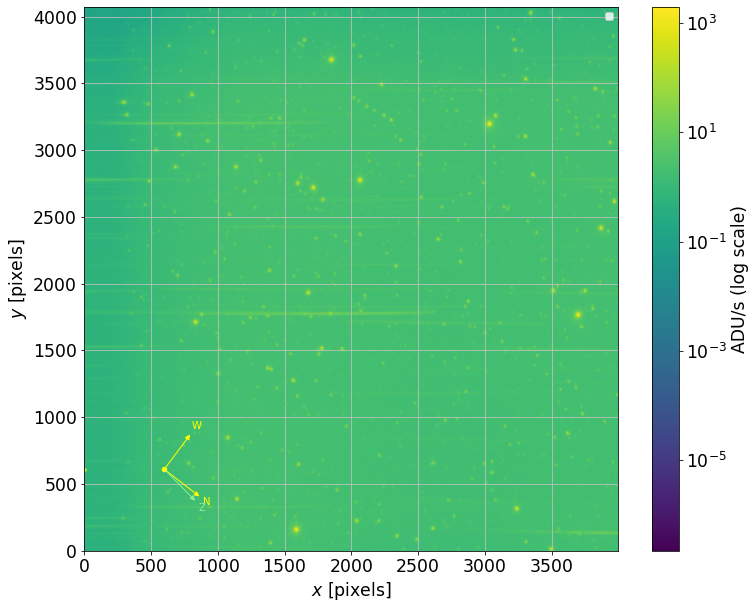

In [125]:
image.plot_image(figsize=(12, 10),scale="log")

In [126]:
filename_image

'holo4_003_empty_PNG321.0+03.9_20210909_000177_quickLookExp.fits'

# Open image in astropy

In [127]:
sky_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (224.97283918, -54.3020902)>

In [128]:
hdu = fits.open(filename_image)

In [129]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-09-10T00:08:53.255'                                             
DATE-OBS= '2021-09-10T00:08:27.395'                                             
DATE-BEG= '2021-09-10T00:08:27.395'                                             
DATE-END= '2021-09-10T00:09:27.622'                                             
MJD     =     59467.0061719347                                                  
MJD-OBS =     59467.00587262

In [130]:
header=hdu[0].header
image=hdu[1].data

In [131]:
wcs = WCS(header)

2021-10-04 15:17:16  astroquery _showwarning         WARNING FITSFixedWarning: The WCS transformation has more axes (2) than the image it is associated with (0)
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
2021-10-04 15:17:16  astroquery _showwarning         WARNING FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   -70.749417 from OBSGEO-[XYZ].
Set OBSGEO-B to   -30.244639 from OBSGEO-[XYZ].
Set OBSGEO-H to     2659.990 from OBSGEO-[XYZ]'.


In [132]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 224.970833333333  -54.3019444444444  
CRPIX : 2000.0  2036.0  
CD1_1 CD1_2  : -0.0957509796129229  0.0430900209232442  
CD2_1 CD2_2  : -0.0430900209232442  -0.0957509796129229  
NAXIS : 0  0


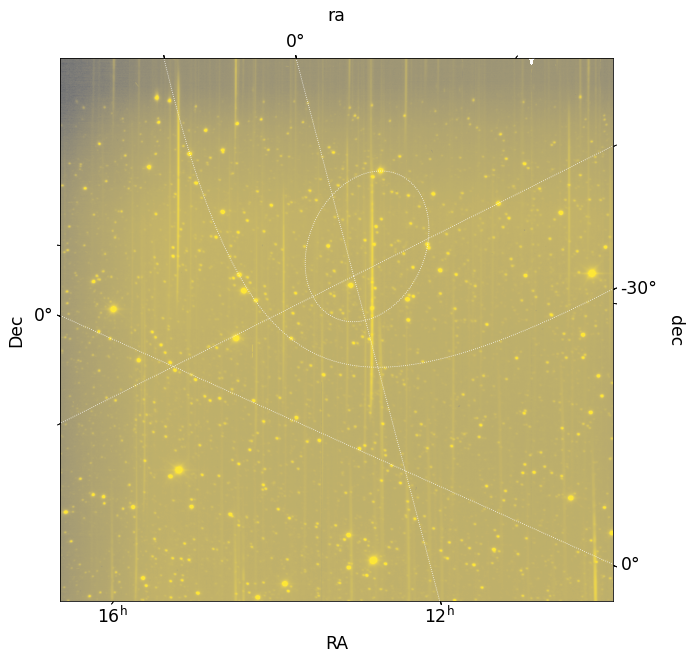

In [135]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=wcs)
plt.imshow(image, cmap='cividis', aspect='equal',norm=LogNorm(0.1,1000))
plt.xlabel(r'RA')
plt.ylabel(r'Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

# Remove temporary file

In [134]:
# os.remove(filename_image)